# Assignment: More Xarray with El Niño-Southern Oscillation (ENSO) Data

Here will will calculate the NINO 3.4 index of El Nino variabillity and use it to analyze datasets.

First read [this page from NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst). It tells you the following:

- The Niño 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

(Note that "anomaly" means that the seasonal cycle, also called the "climatology" has been removed.)

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

In [2]:
pip install netCDF4 h5netcdf

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### 1. Reproduce the SST curve from the figure below

Use the `sst.mnmean.nc` file that we worked with in class, located at <http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc>.

You don't have to match the stylistic details, or use different colors above and below zero, just the "3mth running mean" curve.

![enso](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)

Load the data as an Xarray dataset. Drop the `time_bnds` variable as we did in class and trim the data to 1950 onward for this assignment.

In [3]:
ds = xr.open_dataset('/data9/GR6901/data/sst.mnmean.nc', drop_variables=['time_bnds']).sel(time=slice('1950-01-01','2024-02-01'))
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 890)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-03-03

Now calculate the climatology and the SST anomaly.

In [4]:
# climatology
dsclim = ds.groupby('time.month').mean(dim='time')
dsclim

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-03-03

In [5]:
# SST anomaly

In [6]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

In [7]:
dsanom = ds.groupby('time.month').apply(remove_time_mean)
dsanom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 890)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 1.311e-06 1.311e-06 1.311e-06 ... nan nan

Now reproduce the plot. Keep the rolling 3-month average of the SST anomaly as a DataArray for the next question.

In [8]:
latMin = dsanom.lat.sel(lat = 5.0, method='nearest')
latMax = dsanom.lat.sel(lat = -5.0, method='nearest')
lonMin = dsanom.lon.sel(lon = 360-170, method='nearest')
lonMax = dsanom.lon.sel(lon = 360-120, method='nearest')

ds34 = dsanom.sel(lat=slice(latMin, latMax), lon=slice(lonMin, lonMax))
weight = np.cos(ds34.coords['lat']*2*np.pi/360)
ds34wm = ds34.weighted(weight).mean(dim = ('lat','lon'))

In [9]:
# Saving rolling 3-month average of the SST anomaly as a DataArray
da34wm = ds34wm.sst

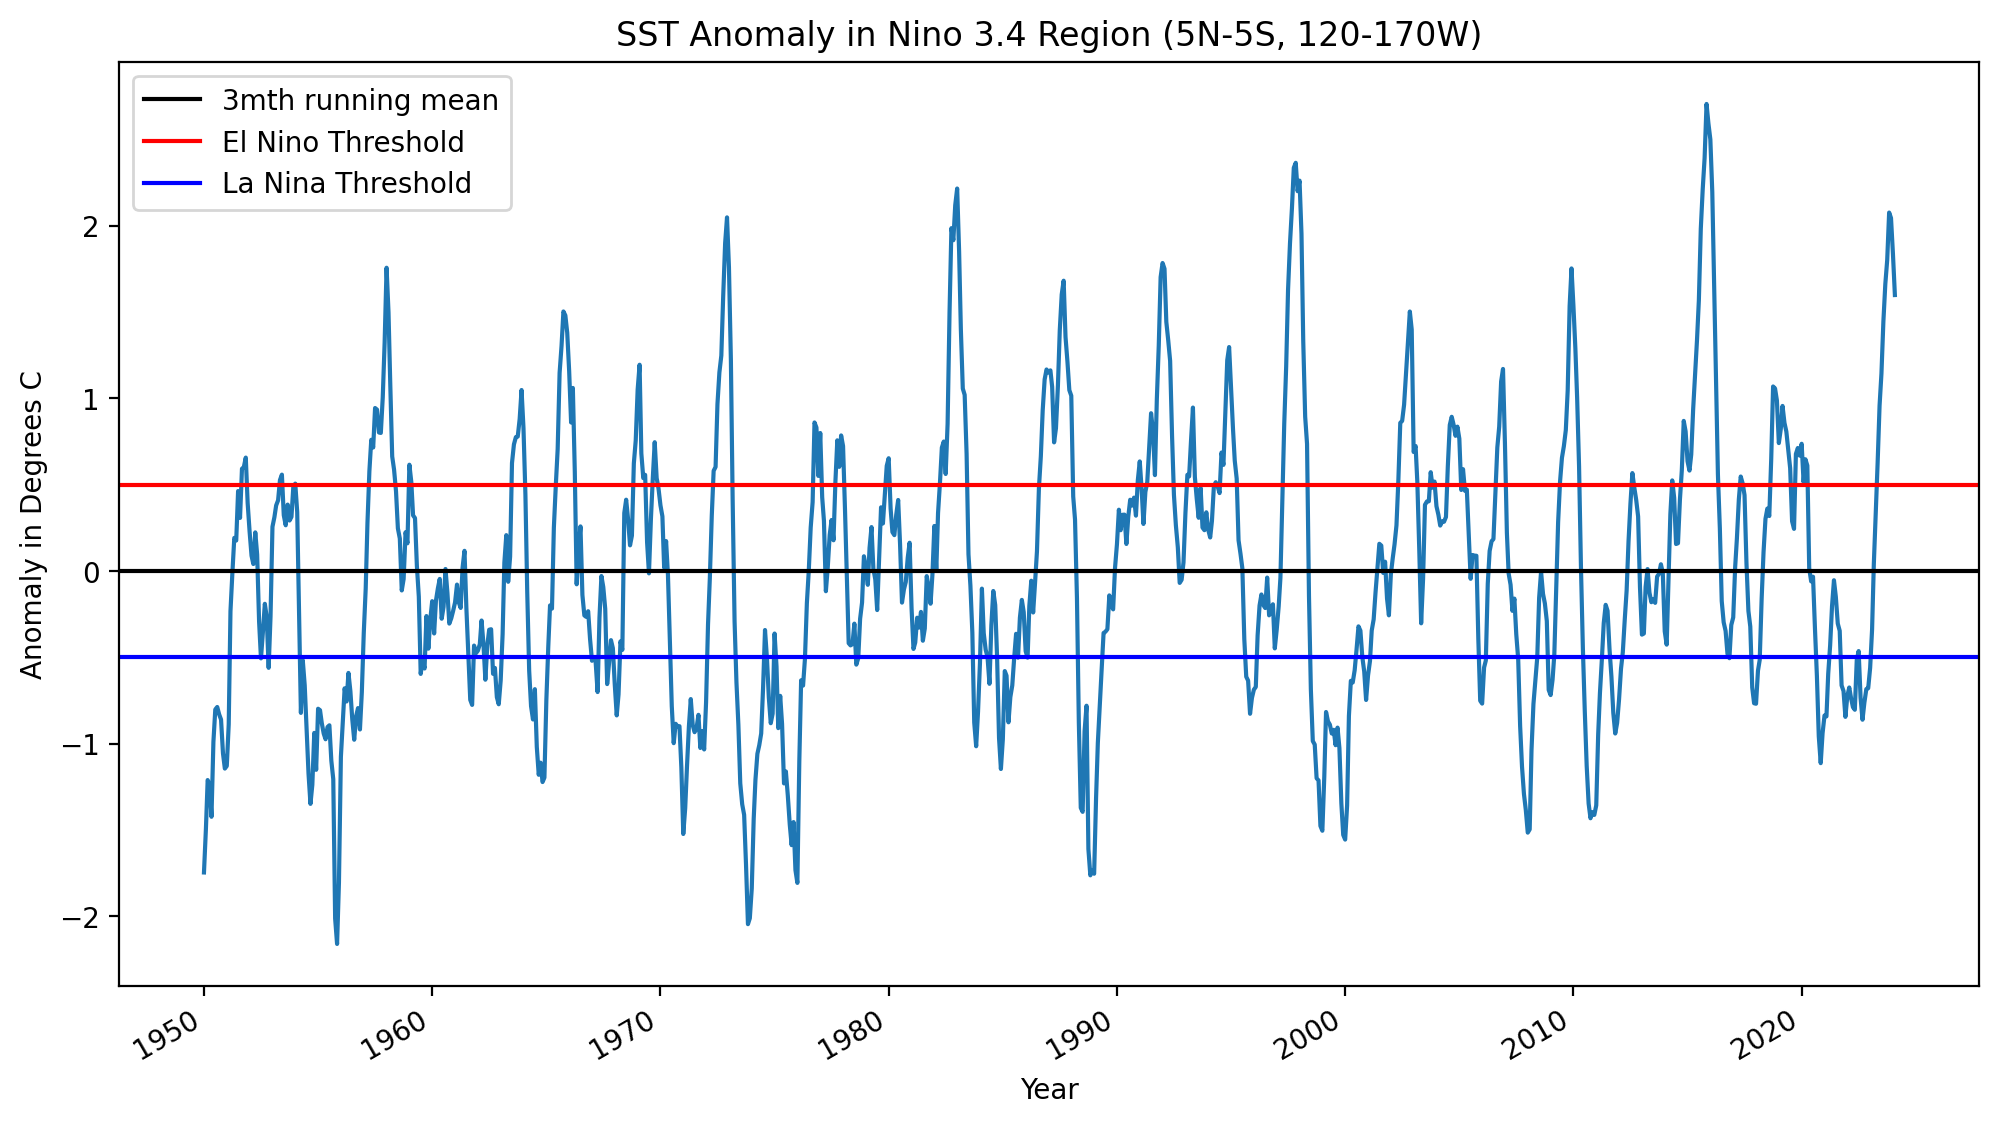

In [10]:
da34wm.plot()
plt.axhline(y=0,color='k', label='3mth running mean')
plt.axhline(y=0.5,color='r', label='El Nino Threshold')
plt.axhline(y=-0.5,color='b', label='La Nina Threshold')
plt.xlabel('Year')
plt.ylabel('Anomaly in Degrees C')
plt.title('SST Anomaly in Nino 3.4 Region (5N-5S, 120-170W)')
plt.legend(loc='best')

### 2. Calculate boolean timeseries representing the positive / negative ENSO phases

Refer to the definitions of warm/cold phases above.

In [11]:
thrPos = 0.5 # degC
thrNeg = -0.5 # degC

dabool = xr.zeros_like(da34wm) # array with indices of above- and below-threshold points

for i in range(0, len(dabool)):
    if da34wm.values[i] >= thrPos:
        dabool.values[i] = 1
    if da34wm.values[i] <= thrNeg:
        dabool.values[i] = -1

onipos = xr.zeros_like(da34wm) # array with indices of positive ONI
onineg = xr.zeros_like(da34wm) # array with indices of negative ONI

for i in range(4, len(dabool)):
    if np.sum(dabool.values[i-4:i+1]) >= 5:
        onipos.values[i-4:i+1] = 1
    if np.sum(dabool.values[i-4:i+1]) <= -5:
        onineg.values[i-4:i+1] = -1

Plot them somehow.

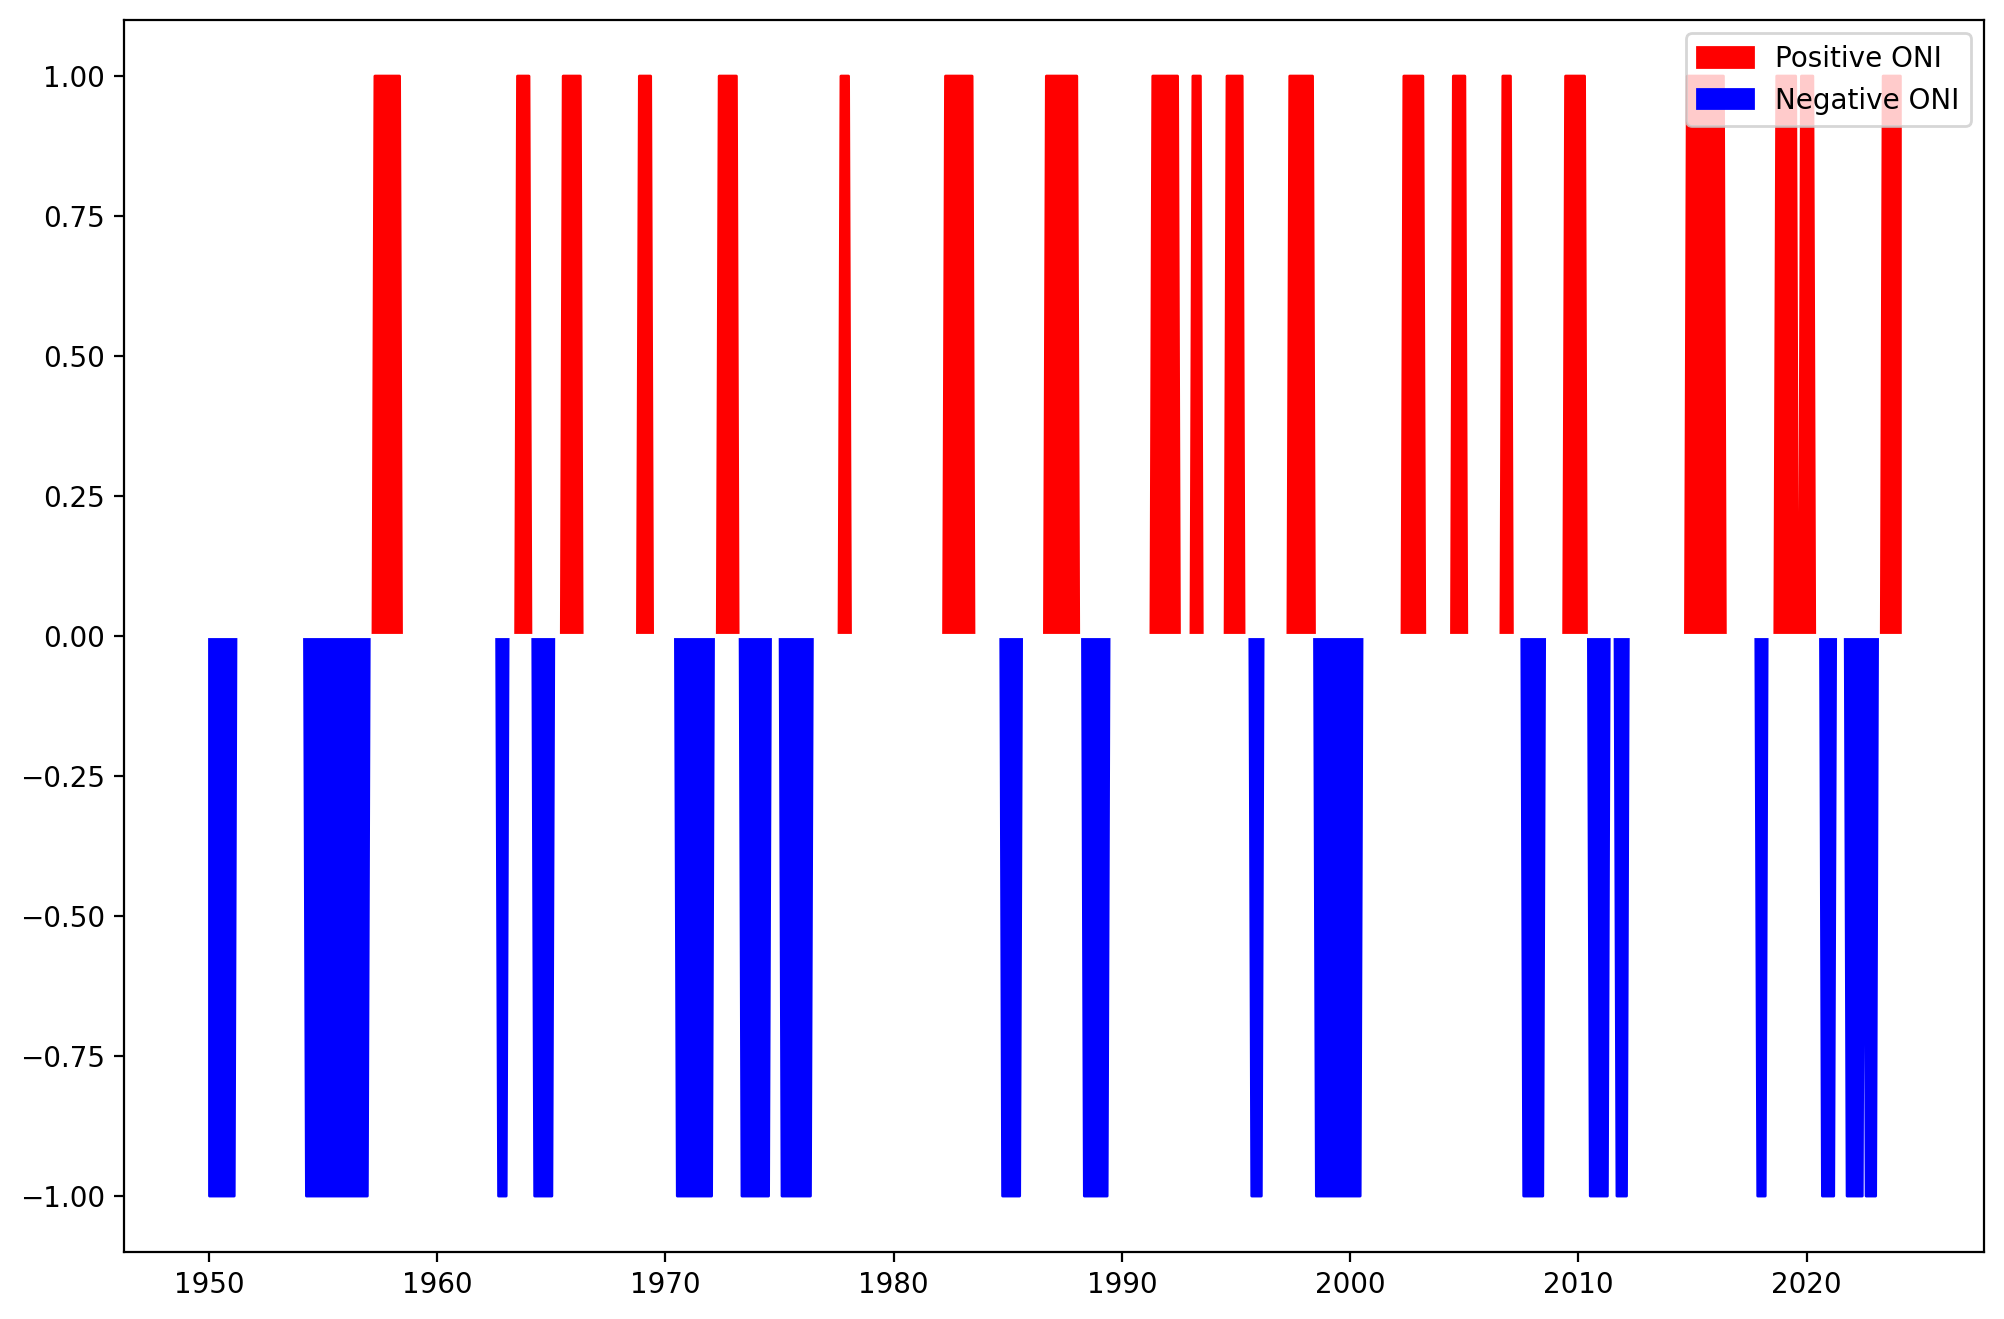

In [12]:
fig, ax = plt.subplots(figsize=(12,8), nrows=1)
plt.fill_between(onipos.time, onipos ,0 , color='red', label='Positive ONI')
plt.fill_between(onineg.time, onineg ,0 , color='blue', label='Negative ONI')
plt.axhline(y=0, color='w')
plt.legend()

### 3. Plot composites of SST anomaly for the positive and negative ENSO regimes

These should be pcolormesh maps. First positive ONI.

Text(0.5, 1.0, 'SST anomaly for positive ONI years since 1950')

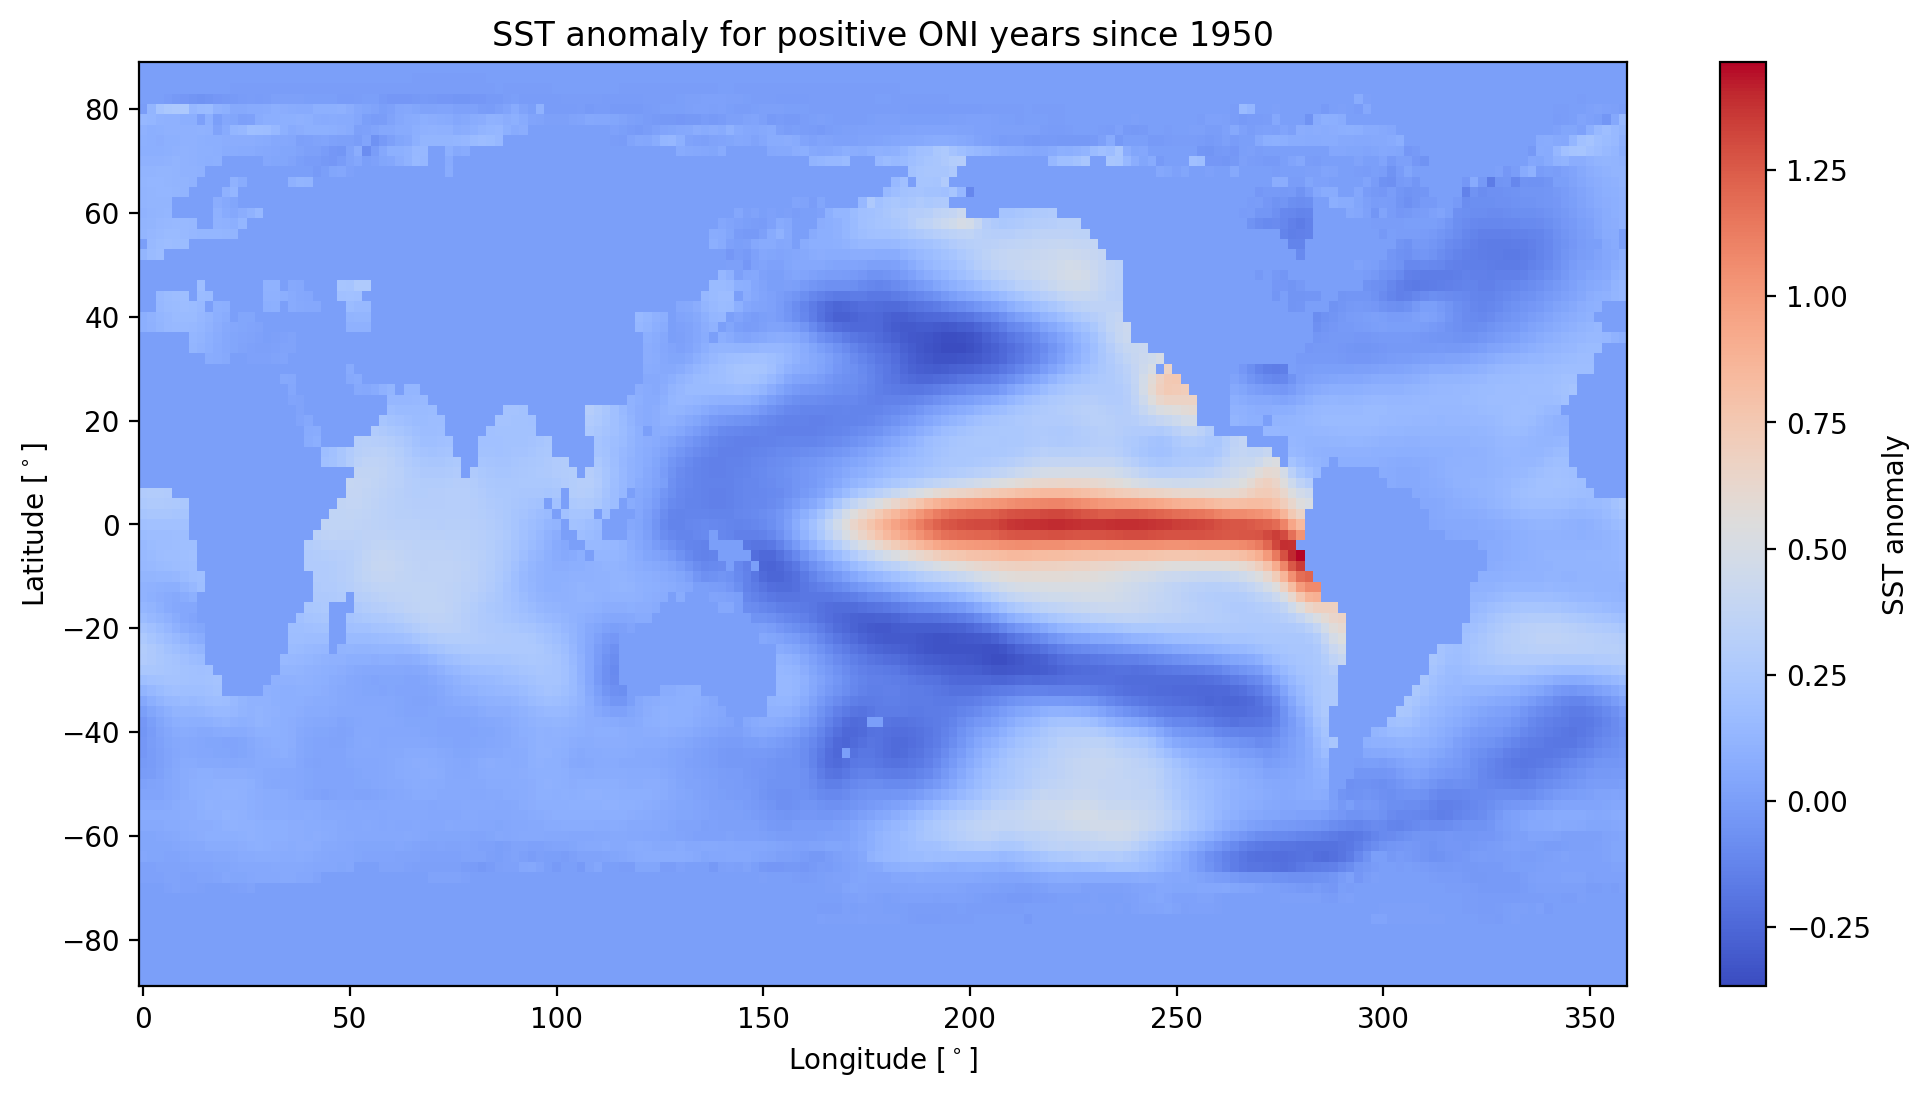

In [13]:
# I am interpreting this to mean 'composites across time'

sstaPOS = dsanom.sst[onipos == 1].fillna(0)

plt.pcolormesh(sstaPOS.lon, sstaPOS.lat, sstaPOS.mean(dim='time'),cmap = 'coolwarm')
plt.colorbar(label='SST anomaly')
plt.xlabel('Longitude [$^\circ$]')
plt.ylabel('Latitude [$^\circ$]')
plt.title('SST anomaly for positive ONI years since 1950')

And negative ONI.

Text(0.5, 1.0, 'SST anomaly for negative ONI years since 1950')

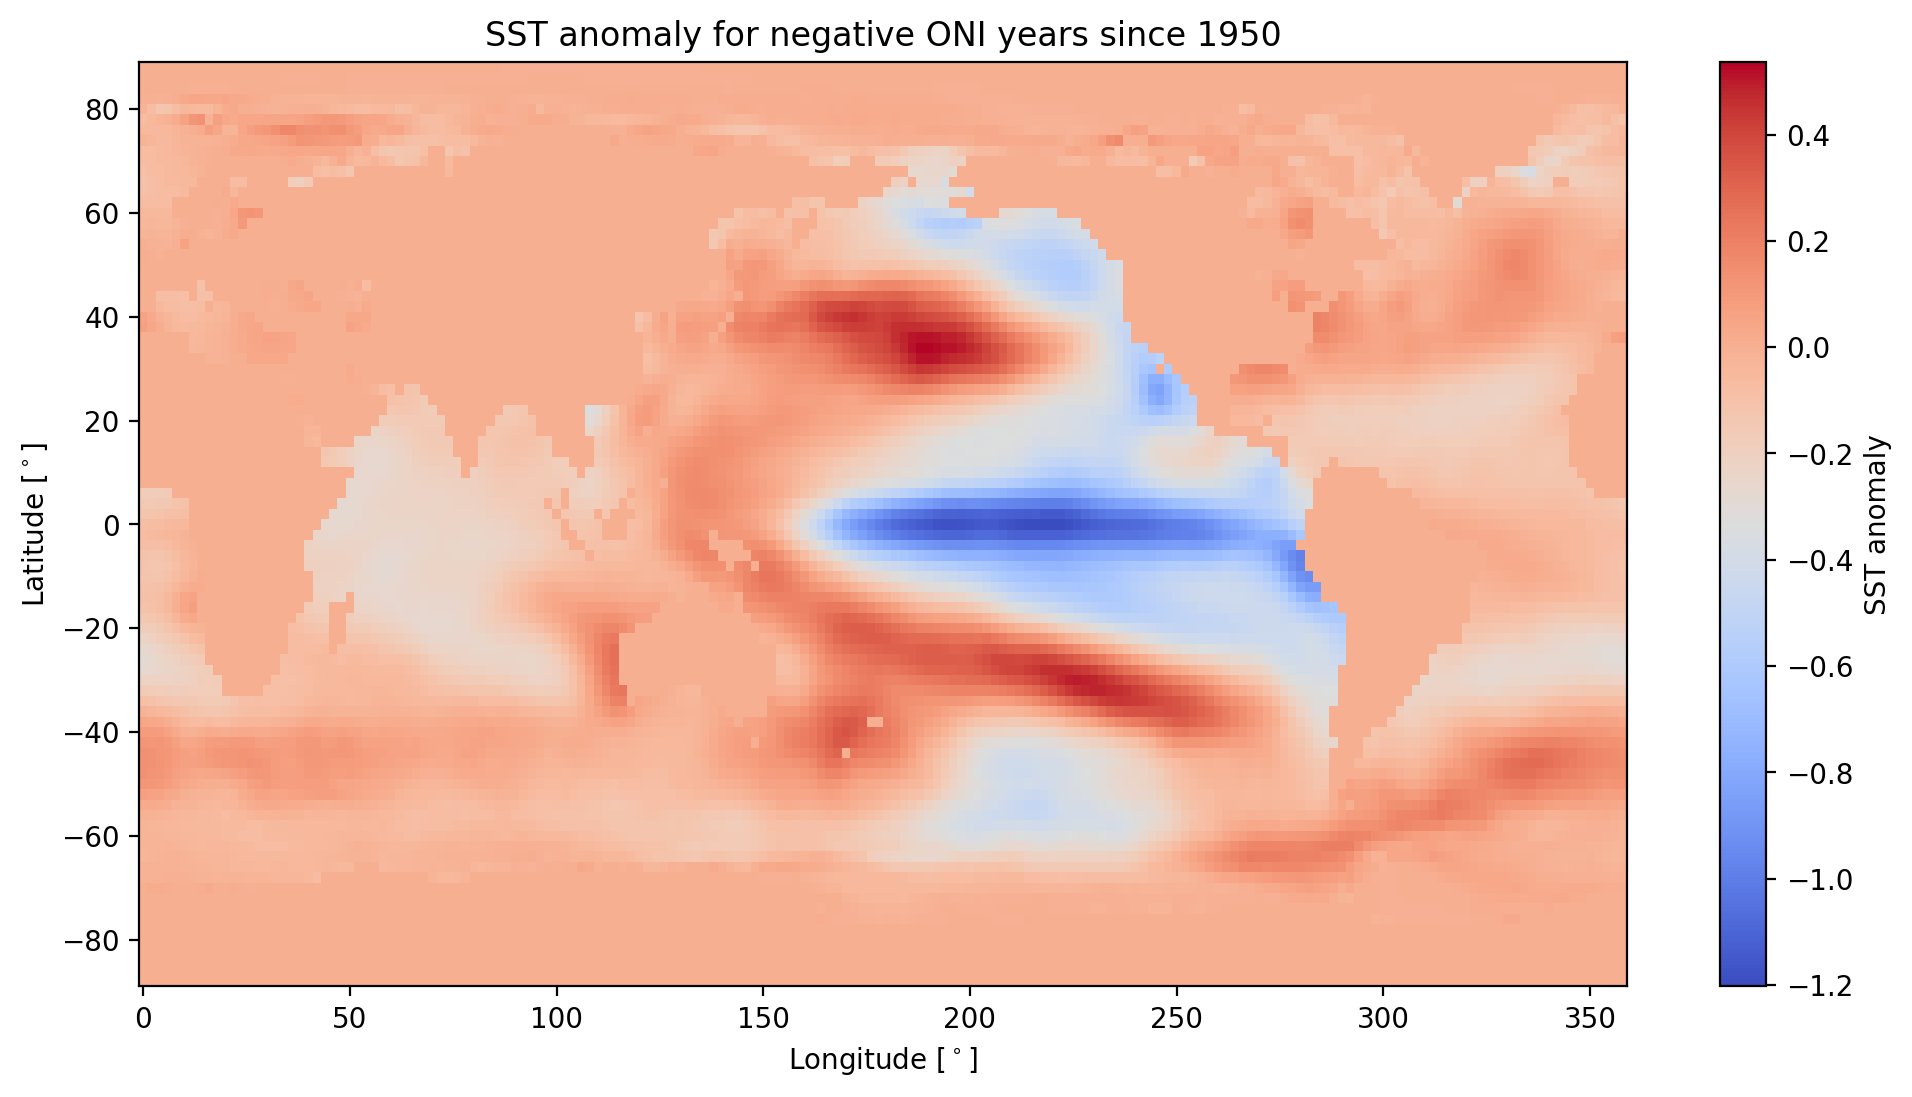

In [14]:
sstaNEG = dsanom.sst[onineg == -1].fillna(0)

plt.pcolormesh(sstaNEG.lon, sstaNEG.lat, sstaNEG.mean(dim='time'),cmap = 'coolwarm')
plt.colorbar(label='SST anomaly')
plt.xlabel('Longitude [$^\circ$]')
plt.ylabel('Latitude [$^\circ$]')
plt.title('SST anomaly for negative ONI years since 1950')

### 4. Calculate the composite of precipitation for positive and negative ENSO phases.

First load the precip dataset. Code to fix the broken time coordinate is included.

In [15]:
import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset>
Dimensions:  (time: 356, Y: 72, X: 144)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1989-08-01
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    prcp     (time, Y, X) float32 nan nan nan nan ... 0.6489 0.6437 0.636 0.6303
Attributes:
    Conventions:  IRIDL

Now plot the *difference* between the time-mean of `prcp` during positive and negative ENSO phases.

Text(0.5, 1.0, 'Difference in precipitation between pos. and neg. ENSO phases - 1960-1989')

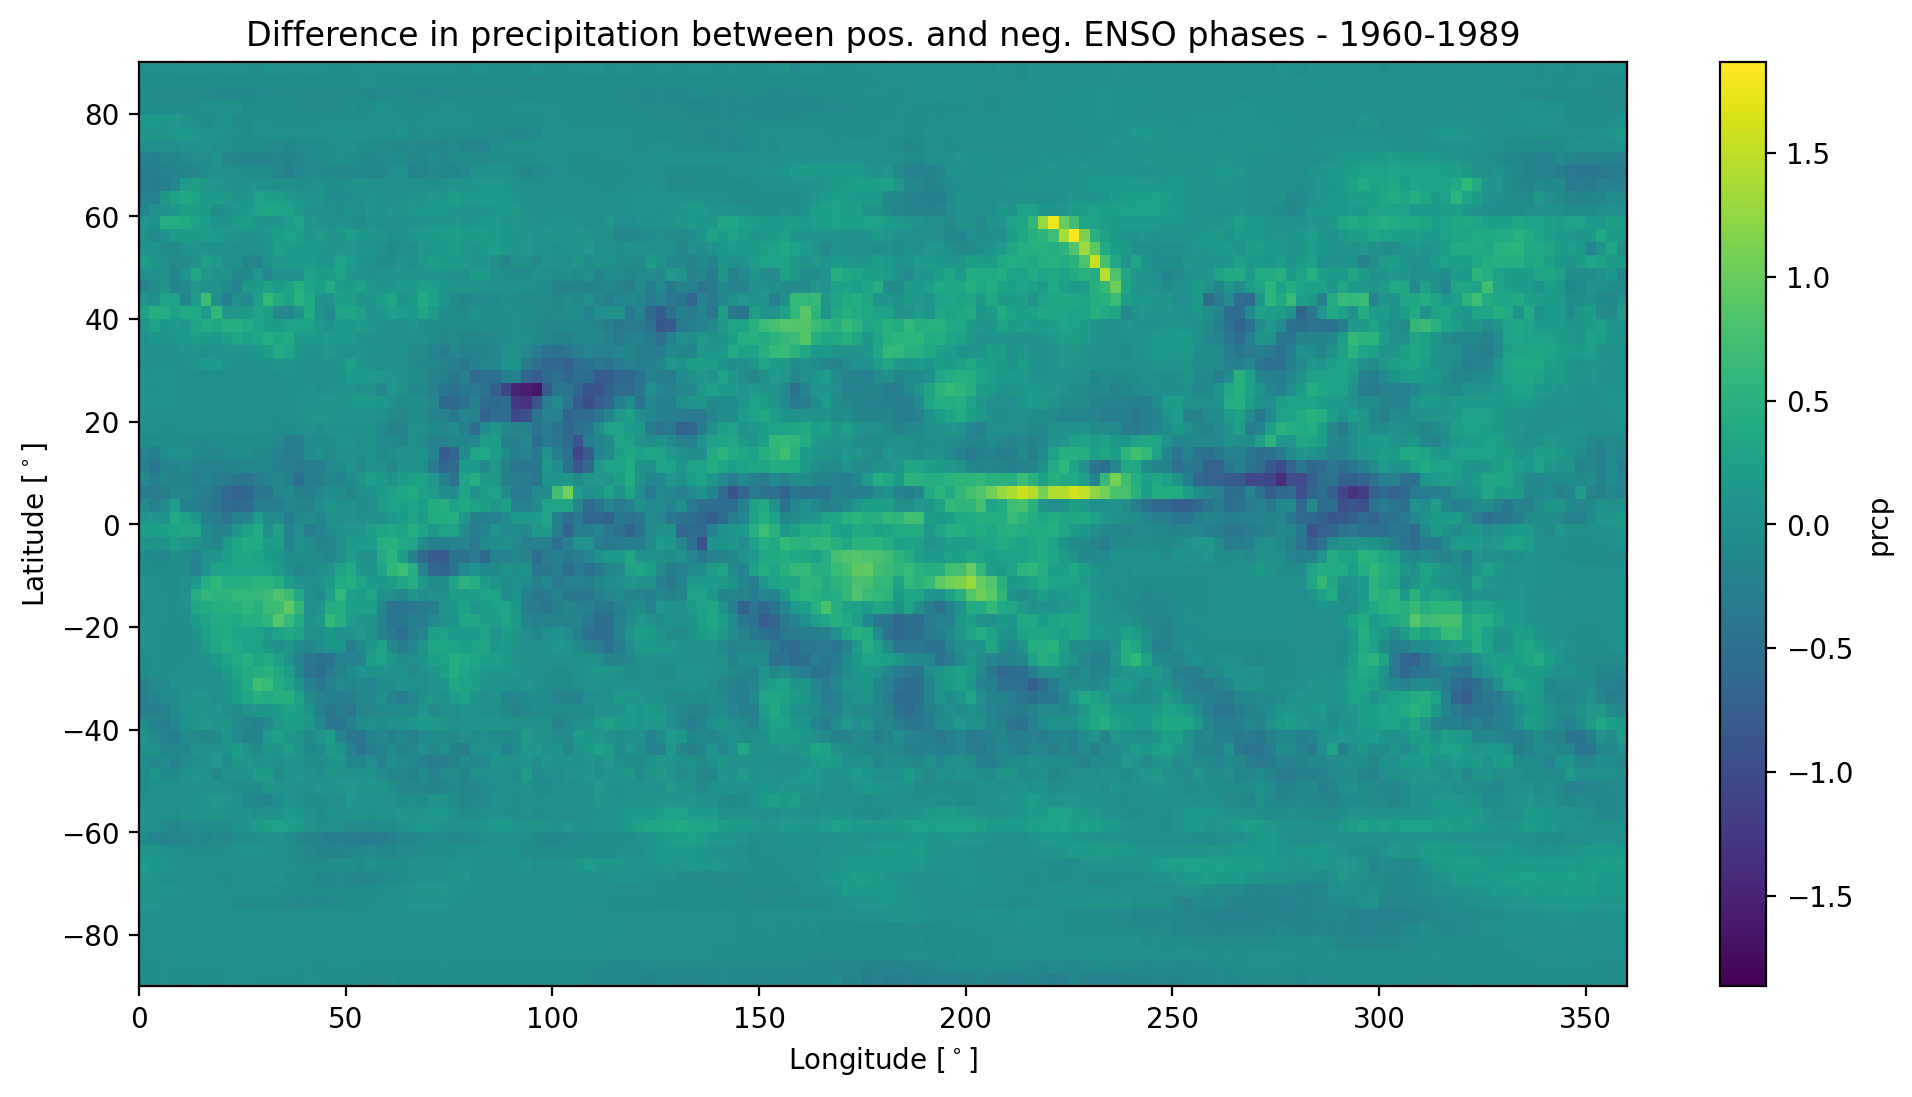

In [16]:
dspStart = dsp.time.isel(time=0).values
dspEnd = dsp.time.isel(time=-1).values

oniposP = onipos.sel(time=slice(dspStart,dspEnd))
oninegP = onineg.sel(time=slice(dspStart,dspEnd))

dsppos = dsp.prcp[oniposP == 1].fillna(0).mean(dim='time')
dspneg = dsp.prcp[oninegP == -1].fillna(0).mean(dim='time')
dspDiff = dsppos-dspneg

dspDiff.plot(cmap='viridis')
plt.xlabel('Longitude [$^\circ$]')
plt.ylabel('Latitude [$^\circ$]')
plt.title('Difference in precipitation between pos. and neg. ENSO phases - 1960-1989')